<a href="https://colab.research.google.com/github/mdsiam135/STI_2025/blob/main/Base_CNN(_3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# =====================================================================
# STEP 1: IMPORT LIBRARIES AND SETUP
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Step 1: Libraries imported successfully!")
print("TensorFlow version:", tf.__version__)


✅ Step 1: Libraries imported successfully!
TensorFlow version: 2.18.0


In [50]:
# =====================================================================
# STEP 2: LOAD DATASETS
# =====================================================================

# Load the three CSV files
print("\n📂 Step 2: Loading datasets...")

# Update these paths to your actual file locations
train_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/validation.csv")
test_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/test.csv")

print(f"✅ Train dataset shape: {train_df.shape}")
print(f"✅ Validation dataset shape: {val_df.shape}")
print(f"✅ Test dataset shape: {test_df.shape}")

# Display first few rows and basic info
print("\n📊 Dataset Info:")
print("Training data columns:")
print(train_df.columns.tolist())
print(f"\nTarget variable stats:")
print(train_df['Production (M.Ton)'].describe())



📂 Step 2: Loading datasets...
✅ Train dataset shape: (3942, 84)
✅ Validation dataset shape: (845, 84)
✅ Test dataset shape: (845, 84)

📊 Dataset Info:
Training data columns:
['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhaka', 'District_Dinajpur', 'District_Fari

In [51]:
# =====================================================================
# STEP 3: CREATE PRODUCTION LABELS BASED ON QUANTILES
# =====================================================================

print("\n🏷️ Step 3: Creating production labels...")

# Combine all production values to calculate consistent quantiles
all_production = pd.concat([
    train_df['Production (M.Ton)'],
    val_df['Production (M.Ton)'],
    test_df['Production (M.Ton)']
])

# Calculate quantiles (33rd and 66th percentiles)
q33 = all_production.quantile(0.33)
q66 = all_production.quantile(0.66)

print(f"📊 Low threshold (33rd percentile): {q33:.4f}")
print(f"📊 High threshold (66th percentile): {q66:.4f}")

# Function to create labels
def create_labels(production_series):
    labels = []
    for prod in production_series:
        if prod <= q33:
            labels.append('low')
        elif prod <= q66:
            labels.append('medium')
        else:
            labels.append('high')
    return labels

# Create labels for each dataset
train_df['production_label'] = create_labels(train_df['Production (M.Ton)'])
val_df['production_label'] = create_labels(val_df['Production (M.Ton)'])
test_df['production_label'] = create_labels(test_df['Production (M.Ton)'])

# Display label distribution
print("\n📈 Label distribution:")
print("Training set:")
print(train_df['production_label'].value_counts())
print("\nValidation set:")
print(val_df['production_label'].value_counts())
print("\nTest set:")
print(test_df['production_label'].value_counts())



🏷️ Step 3: Creating production labels...
📊 Low threshold (33rd percentile): 1075.0000
📊 High threshold (66th percentile): 3907.3258

📈 Label distribution:
Training set:
production_label
high      1339
low       1306
medium    1297
Name: count, dtype: int64

Validation set:
production_label
medium    290
low       279
high      276
Name: count, dtype: int64

Test set:
production_label
high      300
low       275
medium    270
Name: count, dtype: int64


In [52]:
# =====================================================================
# STEP 4: PREPARE FEATURES AND TARGETS
# =====================================================================

print("\n🔧 Step 4: Preparing features and targets...")

# Define feature columns (excluding target and label columns)
feature_columns = [col for col in train_df.columns
                  if col not in ['Production (M.Ton)', 'production_label']]

print(f"✅ Number of features: {len(feature_columns)}")
print("Feature sample:", feature_columns[:10])

# Extract features
X_train = train_df[feature_columns].values
X_val = val_df[feature_columns].values
X_test = test_df[feature_columns].values

# Handle missing values (replace NaN with 0)
X_train = np.nan_to_num(X_train)
X_val = np.nan_to_num(X_val)
X_test = np.nan_to_num(X_test)

print(f"✅ Features extracted - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")



🔧 Step 4: Preparing features and targets...
✅ Number of features: 83
Feature sample: ['Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)']
✅ Features extracted - Train: (3942, 83), Val: (845, 83), Test: (845, 83)


In [53]:
# =====================================================================
# STEP 5: SCALE FEATURES
# =====================================================================

print("\n⚖️ Step 5: Scaling features...")

# Initialize and fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled successfully!")
print(f"Scaled train shape: {X_train_scaled.shape}")


⚖️ Step 5: Scaling features...
✅ Features scaled successfully!
Scaled train shape: (3942, 83)


In [54]:
# =====================================================================
# STEP 6: RESHAPE DATA FOR CNN AND ENCODE LABELS
# =====================================================================

print("\n🔄 Step 6: Reshaping data for CNN...")

# Reshape for CNN (add channel dimension)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
all_labels = np.concatenate([
    train_df['production_label'].values,
    val_df['production_label'].values,
    test_df['production_label'].values
])
label_encoder.fit(all_labels)

y_train = label_encoder.transform(train_df['production_label'].values)
y_val = label_encoder.transform(val_df['production_label'].values)
y_test = label_encoder.transform(test_df['production_label'].values)

# Convert to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

print(f"✅ Data reshaped - CNN input shape: {X_train_cnn.shape}")
print(f"✅ Labels encoded - shape: {y_train_cat.shape}")
print(f"Label classes: {label_encoder.classes_}")



🔄 Step 6: Reshaping data for CNN...
✅ Data reshaped - CNN input shape: (3942, 83, 1)
✅ Labels encoded - shape: (3942, 3)
Label classes: ['high' 'low' 'medium']


In [55]:
# =====================================================================
# STEP 7: BUILD CNN MODEL
# =====================================================================

print("\n🏗️ Step 7: Building CNN model...")

# Define input shape
input_shape = (X_train_cnn.shape[1], 1)  # (features, channels)

# Build CNN model
model = Sequential([
    # First Conv1D block
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Second Conv1D block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Third Conv1D block
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    # Flatten and Dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer (3 classes: low, medium, high)
    Dense(3, activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ CNN model built successfully!")
print("\n📋 Model Architecture:")
model.summary()


🏗️ Step 7: Building CNN model...
✅ CNN model built successfully!

📋 Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 81, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 81, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 38, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 38, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 17, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 17, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,342,083 (5.12 MB)

 Trainable params: 1,339,651 (5.11 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [56]:

# =====================================================================
# STEP 8: SETUP TRAINING CALLBACKS
# =====================================================================

print("\n⚙️ Step 8: Setting up training callbacks...")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    verbose=1
)

print("✅ Callbacks configured:")
print("- Early stopping with patience=15")
print("- Learning rate reduction with patience=8")


⚙️ Step 8: Setting up training callbacks...
✅ Callbacks configured:
- Early stopping with patience=15
- Learning rate reduction with patience=8


In [57]:


# =====================================================================
# STEP 9: TRAIN THE MODEL
# =====================================================================

print("\n🚀 Step 9: Training the model...")

# Set training parameters
EPOCHS = 50
BATCH_SIZE = 32

print(f"Training parameters:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Training samples: {len(X_train_cnn)}")
print(f"- Validation samples: {len(X_val_cnn)}")

# Train the model
history = model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("✅ Model training completed!")


🚀 Step 9: Training the model...
Training parameters:
- Epochs: 50
- Batch size: 32
- Training samples: 3942
- Validation samples: 845
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.3759 - loss: 1.5882 - val_accuracy: 0.3680 - val_loss: 1.0904 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.4341 - loss: 1.2623 - val_accuracy: 0.4426 - val_loss: 1.0442 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5122 - loss: 1.0627 - val_accuracy: 0.5858 - val_loss: 0.8692 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5818 - loss: 0.9181 - val_accuracy: 0.6284 - val_loss: 0.7817 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.6187 - loss: 0.8451 - val_accuracy: 0.6710 - val_loss: 0.7207 - learning_rate: 0.0010
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6404 - loss: 0.8152 - val_accur


📊 Step 10: Plotting training history...


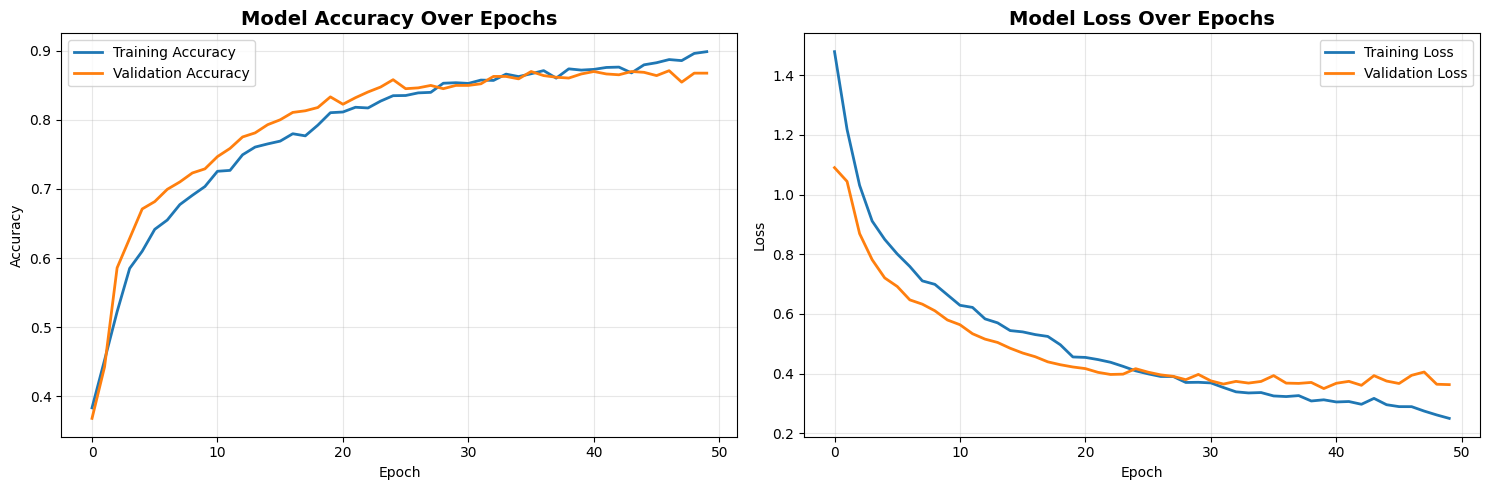

✅ Training history plotted!


In [58]:
# =====================================================================
# STEP 10: PLOT TRAINING HISTORY
# =====================================================================

print("\n📊 Step 10: Plotting training history...")

# Create training history plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training history plotted!")

In [59]:
# =====================================================================
# STEP 11: EVALUATE ON VALIDATION SET
# =====================================================================

print("\n🎯 Step 11: Evaluating on validation set...")

# Make predictions on validation set
y_val_pred_proba = model.predict(X_val_cnn)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='macro')
val_recall = recall_score(y_val, y_val_pred, average='macro')
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("📊 VALIDATION SET RESULTS:")
print("=" * 50)
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision (Macro): {val_precision:.4f}")
print(f"Recall (Macro): {val_recall:.4f}")
print(f"F1 Score (Macro): {val_f1_macro:.4f}")
print(f"F1 Score (Weighted): {val_f1_weighted:.4f}")

# Classification report
print(f"\n📋 Validation Classification Report:")
class_names = label_encoder.classes_
print(classification_report(y_val, y_val_pred, target_names=class_names))



🎯 Step 11: Evaluating on validation set...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
📊 VALIDATION SET RESULTS:
Accuracy: 0.8663
Precision (Macro): 0.8699
Recall (Macro): 0.8667
F1 Score (Macro): 0.8679
F1 Score (Weighted): 0.8672

📋 Validation Classification Report:
              precision    recall  f1-score   support

        high       0.87      0.87      0.87       276
         low       0.94      0.89      0.92       279
      medium       0.79      0.83      0.81       290

    accuracy                           0.87       845
   macro avg       0.87      0.87      0.87       845
weighted avg       0.87      0.87      0.87       845




🔍 Step 12: Plotting validation confusion matrix...


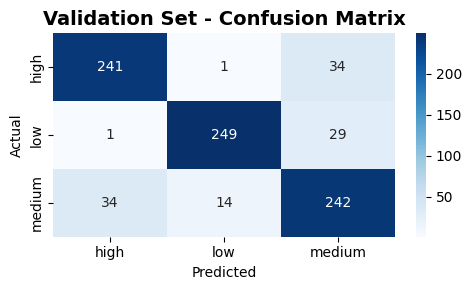

✅ Validation confusion matrix plotted!


In [60]:


# =====================================================================
# STEP 12: PLOT VALIDATION CONFUSION MATRIX
# =====================================================================

print("\n🔍 Step 12: Plotting validation confusion matrix...")

# Create confusion matrix
val_cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Set - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("✅ Validation confusion matrix plotted!")

In [61]:


# =====================================================================
# STEP 13: EVALUATE ON TEST SET
# =====================================================================

print("\n🏁 Step 13: Evaluating on test set...")

# Make predictions on test set
y_test_pred_proba = model.predict(X_test_cnn)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

print("📊 TEST SET RESULTS:")
print("=" * 50)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (Macro): {test_precision:.4f}")
print(f"Recall (Macro): {test_recall:.4f}")
print(f"F1 Score (Macro): {test_f1_macro:.4f}")
print(f"F1 Score (Weighted): {test_f1_weighted:.4f}")

# Classification report
print(f"\n📋 Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))



🏁 Step 13: Evaluating on test set...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
📊 TEST SET RESULTS:
Accuracy: 0.9053
Precision (Macro): 0.9062
Recall (Macro): 0.9045
F1 Score (Macro): 0.9051
F1 Score (Weighted): 0.9057

📋 Test Classification Report:
              precision    recall  f1-score   support

        high       0.91      0.93      0.92       300
         low       0.96      0.92      0.94       275
      medium       0.85      0.87      0.86       270

    accuracy                           0.91       845
   macro avg       0.91      0.90      0.91       845
weighted avg       0.91      0.91      0.91       845




🔍 Step 14: Plotting test confusion matrix...


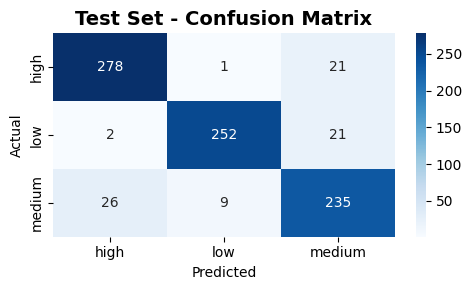

✅ Test confusion matrix plotted!


In [62]:

# =====================================================================
# STEP 14: PLOT TEST CONFUSION MATRIX
# =====================================================================

print("\n🔍 Step 14: Plotting test confusion matrix...")

# Create confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Test Set - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("✅ Test confusion matrix plotted!")

In [63]:


# =====================================================================
# STEP 15: FINAL SUMMARY
# =====================================================================

print("\n🎉 Step 15: Final Summary")
print("=" * 60)

# Create summary table
summary_data = {
    'Dataset': ['Validation', 'Test'],
    'Accuracy': [val_accuracy, test_accuracy],
    'Precision (Macro)': [val_precision, test_precision],
    'Recall (Macro)': [val_recall, test_recall],
    'F1 Score (Macro)': [val_f1_macro, test_f1_macro],
    'F1 Score (Weighted)': [val_f1_weighted, test_f1_weighted]
}

summary_df = pd.DataFrame(summary_data)
print("📊 FINAL PERFORMANCE SUMMARY:")
print(summary_df.round(4))

# Best performing metrics
print(f"\n🏆 BEST RESULTS:")
print(f"Highest Accuracy: {max(val_accuracy, test_accuracy):.4f}")
print(f"Highest Macro F1: {max(val_f1_macro, test_f1_macro):.4f}")

# Model info
total_params = model.count_params()
print(f"\n🔧 MODEL INFO:")
print(f"Total Parameters: {total_params:,}")
print(f"Training Epochs: {len(history.history['accuracy'])}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

print("\n✅ PIPELINE COMPLETED SUCCESSFULLY! 🎉")



🎉 Step 15: Final Summary
📊 FINAL PERFORMANCE SUMMARY:
      Dataset  Accuracy  Precision (Macro)  Recall (Macro)  F1 Score (Macro)  \
0  Validation    0.8663             0.8699          0.8667            0.8679   
1        Test    0.9053             0.9062          0.9045            0.9051   

   F1 Score (Weighted)  
0               0.8672  
1               0.9057  

🏆 BEST RESULTS:
Highest Accuracy: 0.9053
Highest Macro F1: 0.9051

🔧 MODEL INFO:
Total Parameters: 1,342,083
Training Epochs: 50
Final Training Accuracy: 0.8985
Final Validation Accuracy: 0.8675

✅ PIPELINE COMPLETED SUCCESSFULLY! 🎉


In [64]:

# =====================================================================
# STEP 16: SAVE MODEL (OPTIONAL)
# =====================================================================

print("\n💾 Step 16: Model saving option...")

# Uncomment the line below to save the model
# model.save('agricultural_production_cnn_model.h5')
# print("✅ Model saved as 'agricultural_production_cnn_model.h5'")

print("\n🔚 All steps completed successfully!")
print("You can now use this trained model for agricultural production classification!")


💾 Step 16: Model saving option...

🔚 All steps completed successfully!
You can now use this trained model for agricultural production classification!
